# Training the model on images

## Imports

In [1]:
# load custom scripts
from dataset import Dataset
from utils import *
import config 

# import the necessary packages
from albumentations.pytorch import ToTensorV2
from imutils import paths
from skimage import io
from sklearn.model_selection import train_test_split
from torch import optim
from torch.nn import CrossEntropyLoss 
from torch.optim import Adam
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from tqdm import tqdm
from utils import EarlyStopping
import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import random
import segmentation_models_pytorch as smp
import time
import torch
import torchmetrics
import os

## Controlling sources of randomness

In [2]:
# Set seed
SEED = 42
seed_all(SEED)

## Setup CUDA

In [3]:
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"[INFO] CUDA version: {torch.version.cuda}")
  
# storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"[INFO] ID of current CUDA device:{torch.cuda.current_device()}")
        
print(f"[INFO] Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Is CUDA supported by this system? True
[INFO] CUDA version: 11.1
[INFO] ID of current CUDA device:0
[INFO] Name of current CUDA device:NVIDIA GeForce RTX 3090


## Load images

In [4]:
# load the image and label filepaths in a sorted manner
imagePaths = sorted(list(paths.list_images(config.IMAGE_DATASET_PATH)))
labelPaths = sorted(list(paths.list_images(config.LABEL_DATASET_PATH)))

trainImages, testImages, trainLabels, testLabels = train_test_split(imagePaths,
                                                                    labelPaths,
                                                                    test_size=0.2,
                                                                    train_size=0.8,
                                                                    random_state=SEED)
testImages, valImages, testLabels, valLabels = train_test_split(testImages, 
                                                                  testLabels,
                                                                  test_size=0.5,
                                                                  train_size=0.5,
                                                                  random_state=SEED)

# get the masks corresponding to the labels
trainMasks = [s.replace('labels', 'masks_9x9') for s in trainLabels]
valMasks = [s.replace('labels', 'masks_9x9') for s in valLabels]

# save testing images to disk
print("[INFO] saving testing image paths...")
f = open(config.TEST_PATHS, "w")
f.write("\n".join(testImages))
f.close()

[INFO] saving testing image paths...


## Example

In [5]:
# new label classes
classes = {1: 'hard coral',
           2: 'hard coral bleached',
           3: 'dead coral',
           4: 'other invertebrates',
           5: 'sand/rubble',
           6: 'other',
           7: 'algae',
           8: 'seagrass',
           9: 'unknown',
           0: 'no label'
          }

In [6]:
a=random.randrange(len(trainImages))
image = io.imread(trainImages[a])
label = io.imread(trainLabels[a])
mask = io.imread(trainMasks[a])

print(f"Image name: {trainImages[a].split('/')[-1]}")
print(f"Image dtype: {image.dtype}, Label dtype: {label.dtype}")

Image name: (1153).JPG
Image dtype: uint8, Label dtype: uint8


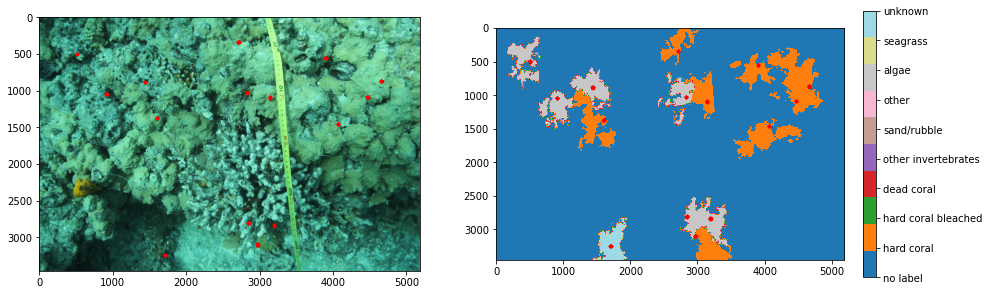

In [7]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 15))
ax[0].imshow(image)
ax[0].scatter(np.nonzero(mask)[1], np.nonzero(mask)[0], s=20, marker='.', c='r')

cax = ax[1].imshow(label, cmap = plt.cm.get_cmap('tab20', 10), vmin=0, vmax=9)
ax[1].scatter(np.nonzero(mask)[1], np.nonzero(mask)[0], s=20, marker='.', c='r')

cbar = fig.colorbar(cax, ticks=list(classes.keys()), fraction=0.035, pad=0.05)
cbar.ax.set_yticklabels(list(classes.values()))
plt.show()

## Transforms

In [8]:
train_transform = A.Compose([
    A.RandomResizedCrop(width=128, height=128, scale=(0.08, 1.0), ratio=(0.75, 1.33), interpolation=cv2.INTER_NEAREST),    
    A.HorizontalFlip(p=0.5),              
    A.RandomRotate90(p=0.5),
    A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1, p=0.5),
    A.GaussianBlur(blur_limit=(3, 7), sigma_limit=0, always_apply=False, p=0.5),
    A.CLAHE(p=0.8),
    A.RandomBrightnessContrast(p=0.8),    
    A.RandomGamma(p=0.8),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()],
    additional_targets={'mask2': 'mask'}
)

In [9]:
val_transform = A.Compose([
    A.RandomResizedCrop(width=128, height=128, scale=(0.08, 1.0), ratio=(0.75, 1.33), interpolation=cv2.INTER_NEAREST),    
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()],
    additional_targets={'mask2': 'mask'}
)

In [10]:
image = io.imread(trainImages[a])
label = io.imread(trainLabels[a])
mask = io.imread(trainMasks[a])
transformed = train_transform(image=image, mask=label, mask2=mask)
image = transformed["image"]
label = transformed["mask"]
mask = transformed["mask2"]
            
# convert label and mask to long tensor
label = label.type(torch.LongTensor)
mask = mask.type(torch.LongTensor)

/tmp/ipykernel_4088907/1473477371.py:10: MatplotlibDeprecationWarning:

Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().



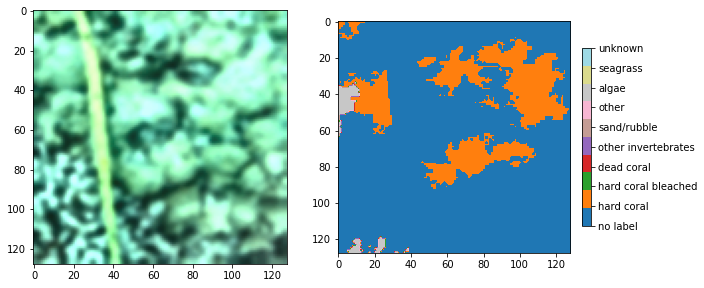

In [11]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 10))
ax[0].imshow(unnormalize(image).permute(1, 2, 0))
ax[0].scatter(np.nonzero(mask)[:,1], np.nonzero(mask)[:,0], s=20, marker='.', c='r')

ax[1].imshow(label,
             cmap = plt.cm.get_cmap('tab20', 10), 
             vmin=0, vmax=9)
ax[1].scatter(np.nonzero(mask)[:,1], np.nonzero(mask)[:,0], s=20, marker='.', c='r')

cbar = fig.colorbar(cax, ticks=list(classes.keys()), fraction=0.035)
cbar.ax.set_yticklabels(list(classes.values()))
plt.show()

## Create dataset

In [12]:
# create the train and validation datasets
startTime = time.time()
trainDS = Dataset(imagePaths=trainImages, labelPaths = trainLabels, maskPaths=trainMasks, transform=train_transform)
valDS = Dataset(imagePaths=valImages, labelPaths = valLabels, maskPaths=valMasks, transform=val_transform)
print(f"[INFO] found {len(trainDS)} examples in the training set")
print(f"[INFO] found {len(valDS)} examples in the validation set")
print(f"[INFO] found {len(testImages)} examples in the test set")
endTime = time.time()
print("[INFO] total time taken to load the data: {:.2f}s".format(endTime - startTime))

[INFO] found 6829 examples in the training set
[INFO] found 854 examples in the validation set
[INFO] found 854 examples in the test set
[INFO] total time taken to load the data: 0.00s


In [13]:
sample = valDS[0]
print(f"Feature shape: {sample[0].shape}, Feature type: {sample[0].dtype}")
print(f"Label shape: {sample[1].shape}, Label type: {sample[1].dtype}")
print(f"Mask shape: {sample[2].shape}, Mask type: {sample[2].dtype}")

Feature shape: torch.Size([3, 128, 128]), Feature type: torch.float32
Label shape: torch.Size([128, 128]), Label type: torch.int64
Mask shape: torch.Size([128, 128]), Mask type: torch.int64


In [14]:
# create the training and validation data loaders
trainLoader = DataLoader(trainDS, shuffle=True, 
                         batch_size=config.BATCH_SIZE, 
                         pin_memory=config.PIN_MEMORY, 
                         num_workers=os.cpu_count(),
                         persistent_workers=True,
                         worker_init_fn=seed_worker)

valLoader = DataLoader(valDS, shuffle=False, 
                       batch_size=config.BATCH_SIZE, 
                       pin_memory=config.PIN_MEMORY, 
                       num_workers=os.cpu_count(),
                       persistent_workers=True,
                       worker_init_fn=seed_worker)

In [15]:
print(f"[INFO] batch_size:{config.BATCH_SIZE}")
print(f"[INFO] num_workers:{os.cpu_count()}")

[INFO] batch_size:700
[INFO] num_workers:32


## Model initialization

In [16]:
# import a pretrained model
model = smp.Unet(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    in_channels=3,      
    classes=len(classes)
)

In [17]:
# initialize model
unet = model.to(config.DEVICE)

# initialize loss function
lossFunc = CrossEntropyLoss(ignore_index=0)

# initialize optimizer
opt = Adam(unet.parameters(), lr=config.INIT_LR)

# calculate steps per epoch for training and validation set
trainSteps = len(trainDS) // config.BATCH_SIZE
valSteps = len(valDS) // config.BATCH_SIZE

# initialize a dictionary to store training history
H = {"train_loss": [], "validation_loss": []}

In [18]:
# initialize metrics
acc = torchmetrics.Accuracy(ignore_index=0)

# move the metrics to device
acc.to(config.DEVICE)

# initialize a dictionary to store metrics history
metrics = {"train_accuracyGT": [], "val_accuracyGT": [],
          "train_accuracyAGT": [], "val_accuracyAGT": [],
          "train_accuracyAGT2": [], "val_accuracyAGT2": []}

In [19]:
# initialize the early_stopping object
early_stopping = EarlyStopping(patience=10, verbose=True, 
                               path="/data/jantina/CoralNet/dataset/output/checkpoint.pt")

In [20]:
#initialize scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, "min", patience=4, verbose=1)
grad_scaler = torch.cuda.amp.GradScaler(enabled=False)

## Training loop

In [21]:
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(config.NUM_EPOCHS)):
    #fix seed
    seed_all(SEED)
    
    ###################
    # train the model #
    ###################
    unet.train() # prep model for training

    # initialize the total training and validation loss
    totalTrainLoss, totalValLoss = 0, 0
    
    # initialize the accuracy
    accTrainGT = 0
    accTrainAGT = 0
    accTrainAGT2 = 0
    accValGT = 0
    accValAGT = 0
    accValAGT2 = 0
    countTrainGT = 0
    countTrainAGT = 0
    countTrainAGT2 = 0
    countValGT = 0
    countValAGT = 0
    countValAGT2 = 0
    
    # loop over the training set
    for batch, (data, target, mask) in enumerate(trainLoader, 1):
        #fix seed
        seed_all(SEED)
        
        # send the input to the device
        (data, target, mask) = (data.to(config.DEVICE), target.to(config.DEVICE), mask.to(config.DEVICE))
        
        # perform a forward pass 
        pred = unet(data)

        # initialize losses
        lossTrainGT, lossTrainAGT = 0, 0
        
        # for each input
        for i in range(len(target)):
            if torch.sum(mask[i])!=0: # GT and AGT
                # update the accuracy count
                countTrainGT = countTrainGT + 1
                countTrainAGT = countTrainAGT + 1
                countTrainAGT2 = countTrainAGT2 + 1
                # extract the GT label positions in the prediction
                pixel_predGT = torch.mul(mask[i], torch.argmax(pred[i],dim=0))
                # extract the GT label positions in the target
                pixel_targGT = torch.mul(mask[i], target[i])
                # metrics on current element
                accTrainGT += acc(pixel_predGT, pixel_targGT).item()
                # loss function
                lossTrainGT += lossFunc(torch.unsqueeze(torch.mul(pred[i],mask[i]),0),
                                        torch.unsqueeze(target[i],0))
                
                # extract the AGT label positions in the prediction
                pixel_predAGT = torch.argmax(pred[i],dim=0)-pixel_predGT
                # extract the AGT label positions in the target
                pixel_targAGT = target[i]-pixel_targGT
                # metrics on current element
                accTrainAGT2 += acc(pixel_predAGT, pixel_targAGT).item()
                if np.isnan(accuracyAGT(pixel_predAGT, pixel_targAGT).item()):
                    countTrainAGT = countTrainAGT - 1
                else:
                    accTrainAGT += accuracyAGT(pixel_predAGT, pixel_targAGT).item()
                # loss function
                lossTrainAGT += lossFunc(torch.unsqueeze(pred[i]-torch.mul(pred[i],mask[i]),0), 
                                         torch.unsqueeze(target[i],0))
                
            else: # only AGT
                # update the accuracy count
                countTrainAGT = countTrainAGT + 1
                countTrainAGT2 = countTrainAGT2 + 1
                # metrics on current element
                accTrainAGT2 += acc(torch.argmax(pred[i],dim=0), target[i]).item()
                if np.isnan(accuracyAGT(torch.argmax(pred[i],dim=0), target[i]).item()):
                    countTrainAGT = countTrainAGT - 1
                else:
                    accTrainAGT += accuracyAGT(torch.argmax(pred[i],dim=0), target[i]).item()
                # loss function
                lossTrainAGT += lossFunc(torch.unsqueeze(pred[i],0),
                                         torch.unsqueeze(target[i],0))
        
        loss = (0.6*lossTrainGT/countTrainGT + 0.4*lossTrainAGT/countTrainAGT)
        
        # Gradient descent with optimizer:
        opt.zero_grad(set_to_none=True)
        grad_scaler.scale(loss).backward()
        grad_scaler.step(opt)
        grad_scaler.update()

        # add the loss to the total training loss so far
        totalTrainLoss += loss.item()
        
    ######################    
    # validate the model #
    ######################
    # switch off autograd
    with torch.no_grad():        
        unet.eval() # prep model for evaluation
        
        # loop over the validation set
        for data, target, mask in valLoader:
            #fix seed
            seed_all(SEED)
            
            # send the input to the device
            (data, target, mask) = (data.to(config.DEVICE), target.to(config.DEVICE), mask.to(config.DEVICE))
        
            # make the predictions 
            pred = unet(data)

            # initialize losses
            lossValGT, lossValAGT = 0, 0
            
            # for each input
            for i in range(len(target)):
                if torch.sum(mask[i])!=0: # GT and AGT
                    # update the accuracy count
                    countValGT = countValGT + 1
                    countValAGT = countValAGT + 1
                    countValAGT2 = countValAGT2 + 1
                    # extract the GT label positions in the prediction
                    pixel_predGT = torch.mul(mask[i], torch.argmax(pred[i],dim=0))
                    # extract the GT label positions in the target
                    pixel_targGT = torch.mul(mask[i], target[i])
                    # metrics on current element
                    accValGT += acc(pixel_predGT, pixel_targGT).item()
                    # loss function
                    lossValGT += lossFunc(torch.unsqueeze(torch.mul(pred[i],mask[i]),0),
                                        torch.unsqueeze(target[i],0))

                    # extract the AGT label positions in the prediction
                    pixel_predAGT = torch.argmax(pred[i],dim=0)-pixel_predGT
                    # extract the AGT label positions in the target
                    pixel_targAGT = target[i]-pixel_targGT
                    # metrics on current element
                    accValAGT2 += acc(pixel_predAGT, pixel_targAGT).item()
                    if np.isnan(accuracyAGT(pixel_predAGT, pixel_targAGT).item()):
                        countValAGT = countValAGT - 1
                    else:
                        accValAGT += accuracyAGT(pixel_predAGT, pixel_targAGT).item()
                    # loss function
                    lossValAGT += lossFunc(torch.unsqueeze(pred[i]-torch.mul(pred[i],mask[i]),0), 
                                         torch.unsqueeze(target[i],0))
                    
                else: # only AGT
                    # update the accuracy count
                    countValAGT = countValAGT + 1
                    countValAGT2 = countValAGT2 + 1
                    # metrics on current element
                    accValAGT2 += acc(torch.argmax(pred[i],dim=0), target[i]).item()
                    if np.isnan(accuracyAGT(torch.argmax(pred[i],dim=0), target[i]).item()):
                        countValAGT = countValAGT - 1
                    else:
                        accValAGT += accuracyAGT(torch.argmax(pred[i],dim=0), target[i]).item()
                    # loss function
                    lossValAGT += lossFunc(torch.unsqueeze(pred[i],0),
                                         torch.unsqueeze(target[i],0))

                
            loss = (0.6*lossValGT/countValGT + 0.4*lossValAGT/countValAGT)
            
            # add the loss to the total validation loss so far
            totalValLoss += loss.item()
            
            # scheduler step
            scheduler.step(loss)                  
            
    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgValLoss = totalValLoss / valSteps
    
    # update our training history
    H["train_loss"].append(avgTrainLoss)
    H["validation_loss"].append(avgValLoss)
    
    # calculate the average metrics
    avgaccTrainGT = accTrainGT / countTrainGT
    avgaccTrainAGT = accTrainAGT / countTrainAGT
    avgaccValGT = accValGT / countValGT
    avgaccValAGT = accValAGT / countValAGT 
    avgaccTrainAGT2 = accTrainAGT2 / countTrainAGT2
    avgaccValAGT2 = accValAGT2 / countValAGT2
    
    # update our metrics history
    metrics["train_accuracyGT"].append(avgaccTrainGT)
    metrics["val_accuracyGT"].append(avgaccValGT)
    metrics["train_accuracyAGT"].append(avgaccTrainAGT)
    metrics["val_accuracyAGT"].append(avgaccValAGT)
    metrics["train_accuracyAGT2"].append(avgaccTrainAGT2)
    metrics["val_accuracyAGT2"].append(avgaccValAGT2)
    
    # check early stopping
    early_stopping(avgValLoss, unet)
    if early_stopping.early_stop:
        print("Early stopping")
        break
    
    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, config.NUM_EPOCHS))
    print("Train loss: {:.6f}, Validation loss: {:.4f}".format(avgTrainLoss, avgValLoss))
    
    # print the model metrics information
    print("GT Train Accuracy: {:.4f}".format(avgaccTrainGT))
    print("AGT Train Accuracy: {:.4f}".format(avgaccTrainAGT))
    print("AGT 2 Train Accuracy: {:.4f}".format(avgaccTrainAGT2))
    print("GT Val Accuracy: {:.4f}".format(avgaccValGT))
    print("AGT Val Accuracy: {:.4f}".format(avgaccValAGT))
    print("AGT 2 Val Accuracy: {:.4f}".format(avgaccValAGT2))
    
    
# load the last checkpoint with the best model
unet.load_state_dict(torch.load("/data/jantina/CoralNet/dataset/output/checkpoint.pt"))

# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

[INFO] training the network...


  1%|█▎                                                                                                                           | 1/100 [06:16<10:20:29, 376.05s/it]

Validation loss decreased (inf --> 142676678.000000).  Saving model ...
[INFO] EPOCH: 1/100
Train loss: 0.711903, Validation loss: 142676678.0000
GT Train Accuracy: 0.2312
AGT Train Accuracy: 0.4802
AGT 2 Train Accuracy: 0.2915
GT Val Accuracy: 0.3275
AGT Val Accuracy: 0.2947
AGT 2 Val Accuracy: 0.2935


  2%|██▌                                                                                                                          | 2/100 [12:23<10:06:22, 371.25s/it]

Validation loss decreased (142676678.000000 --> 23589.909180).  Saving model ...
[INFO] EPOCH: 2/100
Train loss: 0.647027, Validation loss: 23589.9092
GT Train Accuracy: 0.2488
AGT Train Accuracy: 0.3437
AGT 2 Train Accuracy: 0.3423
GT Val Accuracy: 0.3477
AGT Val Accuracy: 0.3010
AGT 2 Val Accuracy: 0.2994


  4%|█████                                                                                                                         | 4/100 [24:38<9:49:46, 368.61s/it]

Validation loss decreased (378.451725 --> 3.687482).  Saving model ...
[INFO] EPOCH: 4/100
Train loss: 0.631150, Validation loss: 3.6875
GT Train Accuracy: 0.3550
AGT Train Accuracy: 0.3828
AGT 2 Train Accuracy: 0.3813
GT Val Accuracy: 0.3308
AGT Val Accuracy: 0.3968
AGT 2 Val Accuracy: 0.3935


  5%|██████▎                                                                                                                       | 5/100 [30:28<9:33:26, 362.17s/it]

Validation loss decreased (3.687482 --> 2.279547).  Saving model ...
[INFO] EPOCH: 5/100
Train loss: 0.627340, Validation loss: 2.2795
GT Train Accuracy: 0.3433
AGT Train Accuracy: 0.4070
AGT 2 Train Accuracy: 0.4057
GT Val Accuracy: 0.3737
AGT Val Accuracy: 0.4349
AGT 2 Val Accuracy: 0.4331


  6%|███████▌                                                                                                                      | 6/100 [36:21<9:22:06, 358.79s/it]

EarlyStopping counter: 1 out of 10
[INFO] EPOCH: 6/100
Train loss: 0.624008, Validation loss: 2.2833
GT Train Accuracy: 0.4116
AGT Train Accuracy: 0.4432
AGT 2 Train Accuracy: 0.4414
GT Val Accuracy: 0.3904
AGT Val Accuracy: 0.4391
AGT 2 Val Accuracy: 0.4382


  7%|████████▊                                                                                                                     | 7/100 [42:12<9:12:29, 356.45s/it]

Validation loss decreased (2.279547 --> 2.268233).  Saving model ...
[INFO] EPOCH: 7/100
Train loss: 0.624188, Validation loss: 2.2682
GT Train Accuracy: 0.4364
AGT Train Accuracy: 0.4492
AGT 2 Train Accuracy: 0.4476
GT Val Accuracy: 0.3952
AGT Val Accuracy: 0.4506
AGT 2 Val Accuracy: 0.4492


  8%|██████████                                                                                                                    | 8/100 [48:06<9:05:16, 355.62s/it]

Validation loss decreased (2.268233 --> 2.256774).  Saving model ...
[INFO] EPOCH: 8/100
Train loss: 0.624605, Validation loss: 2.2568
GT Train Accuracy: 0.4154
AGT Train Accuracy: 0.4523
AGT 2 Train Accuracy: 0.4507
GT Val Accuracy: 0.4206
AGT Val Accuracy: 0.4513
AGT 2 Val Accuracy: 0.4499


  9%|███████████▎                                                                                                                  | 9/100 [53:57<8:57:21, 354.30s/it]

Validation loss decreased (2.256774 --> 2.251703).  Saving model ...
[INFO] EPOCH: 9/100
Train loss: 0.618979, Validation loss: 2.2517
GT Train Accuracy: 0.4534
AGT Train Accuracy: 0.4695
AGT 2 Train Accuracy: 0.4679
GT Val Accuracy: 0.4758
AGT Val Accuracy: 0.5069
AGT 2 Val Accuracy: 0.5060


 10%|████████████▌                                                                                                                | 10/100 [59:46<8:48:56, 352.63s/it]

Validation loss decreased (2.251703 --> 2.235974).  Saving model ...
[INFO] EPOCH: 10/100
Train loss: 0.619210, Validation loss: 2.2360
GT Train Accuracy: 0.4264
AGT Train Accuracy: 0.4614
AGT 2 Train Accuracy: 0.4597
GT Val Accuracy: 0.4633
AGT Val Accuracy: 0.4804
AGT 2 Val Accuracy: 0.4795
Epoch    21: reducing learning rate of group 0 to 7.0000e-03.


 11%|█████████████▌                                                                                                             | 11/100 [1:05:41<8:43:49, 353.14s/it]

EarlyStopping counter: 1 out of 10
[INFO] EPOCH: 11/100
Train loss: 0.625319, Validation loss: 2.2621
GT Train Accuracy: 0.4211
AGT Train Accuracy: 0.4647
AGT 2 Train Accuracy: 0.4629
GT Val Accuracy: 0.5053
AGT Val Accuracy: 0.5018
AGT 2 Val Accuracy: 0.5009


 12%|██████████████▊                                                                                                            | 12/100 [1:11:34<8:38:06, 353.26s/it]

Validation loss decreased (2.235974 --> 2.222912).  Saving model ...
[INFO] EPOCH: 12/100
Train loss: 0.622327, Validation loss: 2.2229
GT Train Accuracy: 0.4849
AGT Train Accuracy: 0.4877
AGT 2 Train Accuracy: 0.4860
GT Val Accuracy: 0.4925
AGT Val Accuracy: 0.5147
AGT 2 Val Accuracy: 0.5132


 13%|███████████████▉                                                                                                           | 13/100 [1:17:32<8:34:02, 354.51s/it]

EarlyStopping counter: 1 out of 10
[INFO] EPOCH: 13/100
Train loss: 0.618303, Validation loss: 2.2393
GT Train Accuracy: 0.4528
AGT Train Accuracy: 0.4841
AGT 2 Train Accuracy: 0.4822
GT Val Accuracy: 0.4870
AGT Val Accuracy: 0.4931
AGT 2 Val Accuracy: 0.4916


 14%|█████████████████▏                                                                                                         | 14/100 [1:23:21<8:25:49, 352.90s/it]

Validation loss decreased (2.222912 --> 2.217029).  Saving model ...
[INFO] EPOCH: 14/100
Train loss: 0.614097, Validation loss: 2.2170
GT Train Accuracy: 0.4673
AGT Train Accuracy: 0.4916
AGT 2 Train Accuracy: 0.4901
GT Val Accuracy: 0.5061
AGT Val Accuracy: 0.5265
AGT 2 Val Accuracy: 0.5250


 15%|██████████████████▍                                                                                                        | 15/100 [1:29:17<8:21:21, 353.91s/it]

EarlyStopping counter: 1 out of 10
[INFO] EPOCH: 15/100
Train loss: 0.615578, Validation loss: 2.2335
GT Train Accuracy: 0.4813
AGT Train Accuracy: 0.5042
AGT 2 Train Accuracy: 0.5027
GT Val Accuracy: 0.4735
AGT Val Accuracy: 0.5297
AGT 2 Val Accuracy: 0.5288


 16%|███████████████████▋                                                                                                       | 16/100 [1:35:09<8:14:50, 353.46s/it]

EarlyStopping counter: 2 out of 10
[INFO] EPOCH: 16/100
Train loss: 0.616610, Validation loss: 2.2217
GT Train Accuracy: 0.4824
AGT Train Accuracy: 0.5056
AGT 2 Train Accuracy: 0.5039
GT Val Accuracy: 0.4867
AGT Val Accuracy: 0.5124
AGT 2 Val Accuracy: 0.5108
Epoch    33: reducing learning rate of group 0 to 7.0000e-04.


 17%|████████████████████▉                                                                                                      | 17/100 [1:40:53<8:04:44, 350.42s/it]

EarlyStopping counter: 3 out of 10
[INFO] EPOCH: 17/100
Train loss: 0.614654, Validation loss: 2.2330
GT Train Accuracy: 0.4718
AGT Train Accuracy: 0.5038
AGT 2 Train Accuracy: 0.5021
GT Val Accuracy: 0.4875
AGT Val Accuracy: 0.5325
AGT 2 Val Accuracy: 0.5316


 18%|██████████████████████▏                                                                                                    | 18/100 [1:46:34<7:55:03, 347.60s/it]

EarlyStopping counter: 4 out of 10
[INFO] EPOCH: 18/100
Train loss: 0.614376, Validation loss: 2.2234
GT Train Accuracy: 0.4731
AGT Train Accuracy: 0.5054
AGT 2 Train Accuracy: 0.5037
GT Val Accuracy: 0.4678
AGT Val Accuracy: 0.5250
AGT 2 Val Accuracy: 0.5241


 19%|███████████████████████▎                                                                                                   | 19/100 [1:52:11<7:45:12, 344.60s/it]

Epoch    38: reducing learning rate of group 0 to 7.0000e-05.
EarlyStopping counter: 5 out of 10
[INFO] EPOCH: 19/100
Train loss: 0.613033, Validation loss: 2.2277
GT Train Accuracy: 0.4846
AGT Train Accuracy: 0.5127
AGT 2 Train Accuracy: 0.5112
GT Val Accuracy: 0.4852
AGT Val Accuracy: 0.5377
AGT 2 Val Accuracy: 0.5361


 20%|████████████████████████▌                                                                                                  | 20/100 [1:57:54<7:38:36, 343.95s/it]

Validation loss decreased (2.217029 --> 2.208457).  Saving model ...
[INFO] EPOCH: 20/100
Train loss: 0.610655, Validation loss: 2.2085
GT Train Accuracy: 0.4882
AGT Train Accuracy: 0.5074
AGT 2 Train Accuracy: 0.5058
GT Val Accuracy: 0.5021
AGT Val Accuracy: 0.5381
AGT 2 Val Accuracy: 0.5353


 21%|█████████████████████████▊                                                                                                 | 21/100 [2:03:35<7:31:44, 343.09s/it]

EarlyStopping counter: 1 out of 10
[INFO] EPOCH: 21/100
Train loss: 0.614204, Validation loss: 2.2299
GT Train Accuracy: 0.4830
AGT Train Accuracy: 0.5074
AGT 2 Train Accuracy: 0.5059
GT Val Accuracy: 0.4930
AGT Val Accuracy: 0.5365
AGT 2 Val Accuracy: 0.5350
Epoch    43: reducing learning rate of group 0 to 7.0000e-06.


 22%|███████████████████████████                                                                                                | 22/100 [2:09:18<7:25:59, 343.07s/it]

EarlyStopping counter: 2 out of 10
[INFO] EPOCH: 22/100
Train loss: 0.612999, Validation loss: 2.2170
GT Train Accuracy: 0.4835
AGT Train Accuracy: 0.5076
AGT 2 Train Accuracy: 0.5061
GT Val Accuracy: 0.5169
AGT Val Accuracy: 0.5380
AGT 2 Val Accuracy: 0.5371


 23%|████████████████████████████▎                                                                                              | 23/100 [2:14:57<7:18:39, 341.81s/it]

EarlyStopping counter: 3 out of 10
[INFO] EPOCH: 23/100
Train loss: 0.614261, Validation loss: 2.2277
GT Train Accuracy: 0.4893
AGT Train Accuracy: 0.5075
AGT 2 Train Accuracy: 0.5057
GT Val Accuracy: 0.5064
AGT Val Accuracy: 0.5425
AGT 2 Val Accuracy: 0.5409


 24%|█████████████████████████████▌                                                                                             | 24/100 [2:20:31<7:10:10, 339.61s/it]

Validation loss decreased (2.208457 --> 2.203622).  Saving model ...
[INFO] EPOCH: 24/100
Train loss: 0.613463, Validation loss: 2.2036
GT Train Accuracy: 0.4875
AGT Train Accuracy: 0.5112
AGT 2 Train Accuracy: 0.5091
GT Val Accuracy: 0.5183
AGT Val Accuracy: 0.5402
AGT 2 Val Accuracy: 0.5387


 25%|██████████████████████████████▊                                                                                            | 25/100 [2:26:13<7:05:15, 340.20s/it]

EarlyStopping counter: 1 out of 10
[INFO] EPOCH: 25/100
Train loss: 0.612119, Validation loss: 2.2191
GT Train Accuracy: 0.4807
AGT Train Accuracy: 0.5112
AGT 2 Train Accuracy: 0.5093
GT Val Accuracy: 0.5191
AGT Val Accuracy: 0.5394
AGT 2 Val Accuracy: 0.5378


 26%|███████████████████████████████▉                                                                                           | 26/100 [2:31:52<6:59:01, 339.76s/it]

EarlyStopping counter: 2 out of 10
[INFO] EPOCH: 26/100
Train loss: 0.616971, Validation loss: 2.2150
GT Train Accuracy: 0.4835
AGT Train Accuracy: 0.5085
AGT 2 Train Accuracy: 0.5069
GT Val Accuracy: 0.5303
AGT Val Accuracy: 0.5399
AGT 2 Val Accuracy: 0.5377
Epoch    53: reducing learning rate of group 0 to 7.0000e-07.


 27%|█████████████████████████████████▏                                                                                         | 27/100 [2:37:34<6:54:17, 340.52s/it]

EarlyStopping counter: 3 out of 10
[INFO] EPOCH: 27/100
Train loss: 0.615212, Validation loss: 2.2135
GT Train Accuracy: 0.4860
AGT Train Accuracy: 0.5100
AGT 2 Train Accuracy: 0.5088
GT Val Accuracy: 0.5112
AGT Val Accuracy: 0.5402
AGT 2 Val Accuracy: 0.5387


 28%|██████████████████████████████████▍                                                                                        | 28/100 [2:43:17<6:49:29, 341.24s/it]

EarlyStopping counter: 4 out of 10
[INFO] EPOCH: 28/100
Train loss: 0.614517, Validation loss: 2.2193
GT Train Accuracy: 0.4875
AGT Train Accuracy: 0.5115
AGT 2 Train Accuracy: 0.5099
GT Val Accuracy: 0.5173
AGT Val Accuracy: 0.5357
AGT 2 Val Accuracy: 0.5347


 29%|███████████████████████████████████▋                                                                                       | 29/100 [2:48:55<6:42:46, 340.38s/it]

Epoch    58: reducing learning rate of group 0 to 7.0000e-08.
EarlyStopping counter: 5 out of 10
[INFO] EPOCH: 29/100
Train loss: 0.620168, Validation loss: 2.2332
GT Train Accuracy: 0.4877
AGT Train Accuracy: 0.5087
AGT 2 Train Accuracy: 0.5074
GT Val Accuracy: 0.5032
AGT Val Accuracy: 0.5409
AGT 2 Val Accuracy: 0.5387


 30%|████████████████████████████████████▉                                                                                      | 30/100 [2:54:23<6:32:42, 336.61s/it]

Validation loss decreased (2.203622 --> 2.189570).  Saving model ...
[INFO] EPOCH: 30/100
Train loss: 0.610566, Validation loss: 2.1896
GT Train Accuracy: 0.4899
AGT Train Accuracy: 0.5109
AGT 2 Train Accuracy: 0.5090
GT Val Accuracy: 0.5050
AGT Val Accuracy: 0.5392
AGT 2 Val Accuracy: 0.5377


 31%|██████████████████████████████████████▏                                                                                    | 31/100 [3:00:04<6:28:28, 337.80s/it]

EarlyStopping counter: 1 out of 10
[INFO] EPOCH: 31/100
Train loss: 0.612078, Validation loss: 2.2112
GT Train Accuracy: 0.4927
AGT Train Accuracy: 0.5113
AGT 2 Train Accuracy: 0.5096
GT Val Accuracy: 0.5168
AGT Val Accuracy: 0.5450
AGT 2 Val Accuracy: 0.5434


 32%|███████████████████████████████████████▎                                                                                   | 32/100 [3:05:43<6:23:25, 338.31s/it]

EarlyStopping counter: 2 out of 10
[INFO] EPOCH: 32/100
Train loss: 0.612040, Validation loss: 2.2222
GT Train Accuracy: 0.4737
AGT Train Accuracy: 0.5126
AGT 2 Train Accuracy: 0.5109
GT Val Accuracy: 0.5086
AGT Val Accuracy: 0.5449
AGT 2 Val Accuracy: 0.5440
Epoch    65: reducing learning rate of group 0 to 7.0000e-09.


 33%|████████████████████████████████████████▌                                                                                  | 33/100 [3:11:21<6:17:48, 338.34s/it]

EarlyStopping counter: 3 out of 10
[INFO] EPOCH: 33/100
Train loss: 0.615609, Validation loss: 2.2195
GT Train Accuracy: 0.4858
AGT Train Accuracy: 0.5103
AGT 2 Train Accuracy: 0.5086
GT Val Accuracy: 0.5145
AGT Val Accuracy: 0.5382
AGT 2 Val Accuracy: 0.5367


 34%|█████████████████████████████████████████▊                                                                                 | 34/100 [3:17:05<6:13:53, 339.91s/it]

EarlyStopping counter: 4 out of 10
[INFO] EPOCH: 34/100
Train loss: 0.615423, Validation loss: 2.2148
GT Train Accuracy: 0.4875
AGT Train Accuracy: 0.5105
AGT 2 Train Accuracy: 0.5090
GT Val Accuracy: 0.4874
AGT Val Accuracy: 0.5332
AGT 2 Val Accuracy: 0.5322


 35%|███████████████████████████████████████████                                                                                | 35/100 [3:22:47<6:08:46, 340.41s/it]

EarlyStopping counter: 5 out of 10
[INFO] EPOCH: 35/100
Train loss: 0.612897, Validation loss: 2.2351
GT Train Accuracy: 0.4825
AGT Train Accuracy: 0.5076
AGT 2 Train Accuracy: 0.5061
GT Val Accuracy: 0.5307
AGT Val Accuracy: 0.5352
AGT 2 Val Accuracy: 0.5343


 36%|████████████████████████████████████████████▎                                                                              | 36/100 [3:28:19<6:00:38, 338.11s/it]

EarlyStopping counter: 6 out of 10
[INFO] EPOCH: 36/100
Train loss: 0.609639, Validation loss: 2.2238
GT Train Accuracy: 0.4944
AGT Train Accuracy: 0.5104
AGT 2 Train Accuracy: 0.5084
GT Val Accuracy: 0.5004
AGT Val Accuracy: 0.5293
AGT 2 Val Accuracy: 0.5285


 37%|█████████████████████████████████████████████▌                                                                             | 37/100 [3:34:01<5:56:11, 339.23s/it]

EarlyStopping counter: 7 out of 10
[INFO] EPOCH: 37/100
Train loss: 0.609454, Validation loss: 2.2042
GT Train Accuracy: 0.4895
AGT Train Accuracy: 0.5124
AGT 2 Train Accuracy: 0.5109
GT Val Accuracy: 0.5102
AGT Val Accuracy: 0.5325
AGT 2 Val Accuracy: 0.5316


 38%|██████████████████████████████████████████████▋                                                                            | 38/100 [3:39:43<5:51:28, 340.14s/it]

EarlyStopping counter: 8 out of 10
[INFO] EPOCH: 38/100
Train loss: 0.615905, Validation loss: 2.2290
GT Train Accuracy: 0.4789
AGT Train Accuracy: 0.5081
AGT 2 Train Accuracy: 0.5066
GT Val Accuracy: 0.5152
AGT Val Accuracy: 0.5362
AGT 2 Val Accuracy: 0.5335


 39%|███████████████████████████████████████████████▉                                                                           | 39/100 [3:45:24<5:45:50, 340.17s/it]

EarlyStopping counter: 9 out of 10
[INFO] EPOCH: 39/100
Train loss: 0.613397, Validation loss: 2.2271
GT Train Accuracy: 0.4829
AGT Train Accuracy: 0.5113
AGT 2 Train Accuracy: 0.5094
GT Val Accuracy: 0.5227
AGT Val Accuracy: 0.5357
AGT 2 Val Accuracy: 0.5342


 39%|███████████████████████████████████████████████▉                                                                           | 39/100 [3:51:07<6:01:30, 355.59s/it]

EarlyStopping counter: 10 out of 10
Early stopping
[INFO] total time taken to train the model: 13867.85s


## Plotting the loss

In [25]:
H = pd.DataFrame(H)

# create figure
fig = go.Figure()
fig.add_trace(go.Scatter(x=H.index, y=H['train_loss'],
                    mode='lines',
                    name='Training Loss'))
fig.add_trace(go.Scatter(x=H.index, y=H['validation_loss'],
                    mode='lines',
                    name='Validation Loss'))

fig.update_layout(title='Training and Testing Loss on Dataset',
                   xaxis_title='Epoch #',
                   yaxis_title='Loss')

fig.update_xaxes(range = [-1,40])
fig.update_yaxes(range = [0,4])

fig.show()

## Plotting the metrics

In [26]:
metrics = pd.DataFrame(metrics)

# create figure
fig = go.Figure()
fig.add_trace(go.Scatter(x=metrics.index, y=metrics['train_accuracyGT'],
                    mode='lines',
                    name='Training accuracy on GT'))
fig.add_trace(go.Scatter(x=metrics.index, y=metrics['val_accuracyGT'],
                    mode='lines',
                    name='Validation accuracy on AGT'))
fig.add_trace(go.Scatter(x=metrics.index, y=metrics['train_accuracyAGT'],
                    mode='lines',
                    name='Training accuracy on GT'))
fig.add_trace(go.Scatter(x=metrics.index, y=metrics['val_accuracyAGT'],
                    mode='lines',
                    name='Validation accuracy on AGT'))

fig.update_layout(title='Metrics',
                   xaxis_title='Epoch #',
                   yaxis_title='Accuracy')

fig.update_xaxes(range = [-1,40])
fig.update_yaxes(range = [0,1])

fig.show()

# Save model

In [24]:
# serialize the model to disk
torch.save(unet, "/data/jantina/CoralNet/dataset/output/unet2.pth")
print("[INFO] model saved !")

[INFO] model saved !
